# Config

In [1]:
import numpy as np
import os
import pandas as pd
import yaml

np.random.seed(3407)
np.set_printoptions(threshold=10, linewidth=1000)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # disable INFO and WARNING log
pd.set_option('display.max_colwidth', 20)

config_path = os.path.join(os.getcwd(), "config.yml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
print(yaml.dump(config, sort_keys=False, default_flow_style=True))
dataset_root_dir = os.path.abspath(os.path.join(os.getcwd(), config["dataset"]["root_dir"]))
available_datasets = config["dataset"]["available"]
download_datasets = config["dataset"]["download"]

{dataset: {root_dir: ../dataset, available: [sift-1m, gist-1m, deep-10m, mnist-8m,
      mtg-40k, glove-twitter-1m, glove-crawl-2m, laion-1m, youtube-6m], download: [
      sift-1m, gist-1m, deep-10m, mnist-8m, mtg-40k, glove-twitter-1m, glove-crawl-2m,
      laion-1m, youtube-6m]}, proxy: {enabled: true, http: 'http://127.0.0.1:7890',
    https: 'http://127.0.0.1:7890', youtube_6m_mirror: asia}}



In [ ]:
import os
import tensorflow as tf
from tqdm import tqdm
import subprocess
import glob
import numpy as np
import pandas as pd

def get_dataset_dir(dataset):
    dataset_dir = dataset_root_dir
    parts = dataset.split('-')
    for part in parts:
        dataset_dir = os.path.join(dataset_dir, part)
    return dataset_dir

def read_vecs(fname):
    data = np.fromfile(fname, dtype='int32')
    dim = data[0]
    vectors = data.reshape(-1, dim + 1)[:, 1:].copy()
    _, ext = os.path.splitext(fname)
    if ext == '.fvecs':
        vectors = vectors.view('float32')
    return vectors

def read_bin(fname):
    data = np.fromfile(fname, dtype='int32')
    n = data[0]
    dim = data[1]
    vectors = data[2:].reshape(-1, dim).copy()
    _, ext = os.path.splitext(fname)
    if ext == '.fbin':
        vectors = vectors.view('float32')
    return vectors

def read_rb(fname, start_line, end_line):
    with open(fname, 'rb') as file:
        lines = file.readlines()
        n = len(lines)
        for line_number in range(start_line, end_line):  # iterate over [start_line, end_line)
            if line_number < n:
                print(f"Line {line_number}: {lines[line_number].strip()}")
            else:
                print(f"Line {line_number} is out of range.")

def read_mnist8m(fname, dim=784, n=1000000, dtype="int"):
    with open(fname, 'r') as f:
        lines = f.readlines()
    n = min(n, len(lines))
    vectors = np.zeros((n, dim), dtype=np.int32)
    labels = np.zeros((n, 1), dtype=np.int32)
    for i, line in tqdm(enumerate(lines[:n]), total=n, dynamic_ncols=True):
        line = line.strip().split()
        labels[i, 0] = int(line[0])
        for elem in line[1:]:
            index, value = elem.split(':')
            if dtype == "int":
                vectors[i, int(index) - 1] = int(value)  # fill dense feature vector
            else:
                vectors[i, int(index) - 1] = float(value)
    return vectors, labels

def show_mnist8m_image(beg=0, end=5):  # show [beg, end)
    script = os.path.join(get_dataset_dir("mnist-8m"), "infimnist", "infimnist")
    script_data_dir = os.path.join(get_dataset_dir("mnist-8m"), "infimnist", "data")
    subprocess.run(f"{script} -d {script_data_dir} disp {10000+beg} {10000+end-1}", shell=True, check=True)

def read_glove(fname, dim):
    with open(fname, 'rb') as f:  # read in binary mode to avoid encoding errors from control characters
        lines = f.readlines()
    n = len(lines)
    vectors = np.zeros((n, dim), dtype=np.float32)
    words = np.empty((n, 1), dtype=object)
    for i, line in tqdm(enumerate(lines[:n]), total=n, dynamic_ncols=True):
        line = line.strip().split()
        words[i, 0] = line[0]
        vectors[i] = np.array(line[1:], dtype=np.float32)
    return vectors, words

def read_parquet_files(dir_path):
    parquet_files = glob.glob(os.path.join(dir_path, "*.parquet"))
    parquet_files.sort()
    df_list = [pd.read_parquet(parquet_file, engine='pyarrow') for parquet_file in tqdm(parquet_files, ncols=len(parquet_files), dynamic_ncols=True)]
    df = pd.concat(df_list, ignore_index=True)
    return df

def read_youtube6m(fname):
    # Parse function for tfrecord fields
    def _parse_function(proto):
        keys_to_features = {
            'id': tf.io.FixedLenFeature([1], tf.string),
            'labels': tf.io.VarLenFeature(tf.int64),
            'mean_rgb': tf.io.FixedLenFeature([1024], tf.float32),
            'mean_audio': tf.io.FixedLenFeature([128], tf.float32),
        }
        parsed_features = tf.io.parse_single_example(proto, keys_to_features)
        return parsed_features

    dataset = tf.data.TFRecordDataset([fname])
    dataset = dataset.map(_parse_function)

    data = []
    for i, record in enumerate(dataset):
        sample_data = {
            "Sample ID": i + 1,
            "ID": record['id'].numpy(),
            "Labels": record['labels'].values.numpy(),
            "Mean RGB": record['mean_rgb'].numpy(),
            "Mean Audio": record['mean_audio'].numpy()
        }
        data.append(sample_data)

    df = pd.DataFrame(data)
    return df

import psutil

def show_memory():
    memory = psutil.virtual_memory()
    total_memory = memory.total
    available_memory = memory.available
    print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")

# sift-1m

In [7]:
vectors_base        = read_vecs(os.path.join(get_dataset_dir("sift-1m"), "sift", "sift_base.fvecs"))
vectors_query       = read_vecs(os.path.join(get_dataset_dir("sift-1m"), "sift", "sift_query.fvecs"))
vectors_groundtruth = read_vecs(os.path.join(get_dataset_dir("sift-1m"), "sift", "sift_groundtruth.ivecs"))

In [ ]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(vectors_query.shape)
print("First 5 query vectors:")
print(vectors_query[:5])
print(50*'-')

print(vectors_groundtruth.shape)
print("First 5 groundtruth:")
print(vectors_groundtruth[:5])
print(50*'-')

(1000000, 128)
First 5 base vectors:
[[ 0. 16. 35. ... 25. 23.  1.]
 [14. 35. 19. ... 11. 21. 33.]
 [ 0.  1.  5. ...  4. 23. 10.]
 [12. 47. 14. ... 27. 29. 21.]
 [ 1.  1.  0. ...  4. 28. 34.]]
--------------------------------------------------
(10000, 128)
First 5 query vectors:
[[  1.   3.  11. ...  42.  48.  11.]
 [ 40.  25.  11. ...   3.  19.  13.]
 [ 28.   4.   3. ...   2.  54.  47.]
 [ 24.  12.  14. ... 103.  16.   0.]
 [  0.   4.  47. ...  69.  45.   2.]]
--------------------------------------------------
(10000, 100)
First 5 groundtruth:
[[932085 934876 561813 ... 398306 931721 989762]
 [413247 413071 706838 ... 855176 846198 987074]
 [669835 408764 408462 ... 310475 971815 937903]
 [970797 125539  48044 ... 443325 886122 780591]
 [340871 748397 748193 ... 109870 693394 240166]]
--------------------------------------------------


# gist-1m

In [10]:
vectors_base        = read_vecs(os.path.join(get_dataset_dir("gist-1m"), "gist", "gist_base.fvecs"))
vectors_query       = read_vecs(os.path.join(get_dataset_dir("gist-1m"), "gist", "gist_query.fvecs"))
vectors_groundtruth = read_vecs(os.path.join(get_dataset_dir("gist-1m"), "gist", "gist_groundtruth.ivecs"))

In [11]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(vectors_query.shape)
print("First 5 query vectors:")
print(vectors_query[:5])
print(50*'-')

print(vectors_groundtruth.shape)
print("First 5 groundtruth:")
print(vectors_groundtruth[:5])
print(50*'-')

(1000000, 960)
First 5 base vectors:
[[0.0459 0.0439 0.0251 ... 0.0429 0.0458 0.0461]
 [0.0375 0.03   0.0332 ... 0.1033 0.0573 0.0492]
 [0.0271 0.0554 0.0304 ... 0.0834 0.0994 0.0606]
 [0.0657 0.0244 0.0227 ... 0.1046 0.1025 0.0684]
 [0.0083 0.0093 0.0482 ... 0.0149 0.0368 0.0604]]
--------------------------------------------------
(1000, 960)
First 5 query vectors:
[[0.0117 0.0115 0.0087 ... 0.0124 0.0603 0.0866]
 [0.0395 0.0384 0.0593 ... 0.0386 0.0403 0.0222]
 [0.0152 0.0244 0.0535 ... 0.0047 0.007  0.0078]
 [0.0208 0.0249 0.0862 ... 0.0648 0.1352 0.0647]
 [0.0205 0.0483 0.0604 ... 0.0568 0.0479 0.0987]]
--------------------------------------------------
(1000, 100)
First 5 groundtruth:
[[786559 624520 726827 ... 562022 809944 230737]
 [330653 347044 427635 ... 649520 719420 152063]
 [242301 857055 314243 ... 369126 928097 156056]
 [229118 680315 550739 ... 197868 162814 639711]
 [172470 288560 789517 ... 841036 989562  17977]]
--------------------------------------------------


# deep-10m

In [12]:
vectors_base        = read_bin(os.path.join(get_dataset_dir("deep-10m"), "base.10M.fbin"))
vectors_query       = read_bin(os.path.join(get_dataset_dir("deep-10m"), "query.public.10K.fbin"))
vectors_groundtruth = read_bin(os.path.join(get_dataset_dir("deep-10m"), "groundtruth.public.10K.ibin"))

In [13]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(vectors_query.shape)
print("First 5 query vectors:")
print(vectors_query[:5])
print(50*'-')

print(vectors_groundtruth.shape)
print("First 5 groundtruth:")
print(vectors_groundtruth[:5])
print(50*'-')

(10000000, 96)
First 5 base vectors:
[[ 0.21529806 -0.0611916   0.08770884 ...  0.03558038  0.10351982 -0.02542253]
 [ 0.13264489  0.05051563 -0.01825295 ...  0.11348495 -0.06511541 -0.0616208 ]
 [ 0.09758992 -0.16071838 -0.08612806 ...  0.11409786  0.01851223  0.06667562]
 [ 0.18771926 -0.11617331  0.01901736 ... -0.01346522 -0.01030397 -0.10662213]
 [ 0.08333722 -0.03015709 -0.07384123 ... -0.19108255 -0.09852702 -0.14285105]]
--------------------------------------------------
(10000, 96)
First 5 query vectors:
[[ 0.07017706  0.1383625  -0.06568797 ...  0.00498914 -0.08495363 -0.00968003]
 [ 0.15406875  0.00376313 -0.10626194 ...  0.13363674  0.01588081 -0.02768049]
 [-0.02407133 -0.08697873 -0.01630606 ... -0.13900514  0.08153283 -0.01804174]
 [ 0.01313017 -0.09876665 -0.23693323 ...  0.05139441  0.00354599 -0.02893664]
 [ 0.07010564  0.04652412 -0.1480498  ...  0.05610413 -0.15321667 -0.02981718]]
--------------------------------------------------
(10000, 100)
First 5 groundtruth:


# mnist-8m

In [14]:
read_rb(os.path.join(get_dataset_dir("mnist-8m"), "mnist8m"), 0, 5)

Line 0: b'5 153:3 154:18 155:18 156:18 157:126 158:136 159:175 160:26 161:166 162:255 163:247 164:127 177:30 178:36 179:94 180:154 181:170 182:253 183:253 184:253 185:253 186:253 187:225 188:172 189:253 190:242 191:195 192:64 204:49 205:238 206:253 207:253 208:253 209:253 210:253 211:253 212:253 213:253 214:251 215:93 216:82 217:82 218:56 219:39 232:18 233:219 234:253 235:253 236:253 237:253 238:253 239:198 240:182 241:247 242:241 261:80 262:156 263:107 264:253 265:253 266:205 267:11 269:43 270:154 290:14 291:1 292:154 293:253 294:90 320:139 321:253 322:190 323:2 348:11 349:190 350:253 351:70 377:35 378:241 379:225 380:160 381:108 382:1 406:81 407:240 408:253 409:253 410:119 411:25 435:45 436:186 437:253 438:253 439:150 440:27 464:16 465:93 466:252 467:253 468:187 494:249 495:253 496:249 497:64 519:46 520:130 521:183 522:253 523:253 524:207 525:2 545:39 546:148 547:229 548:253 549:253 550:253 551:250 552:182 571:24 572:114 573:221 574:253 575:253 576:253 577:253 578:201 579:78 597:23 5

In [15]:
vectors_base, labels = read_mnist8m(os.path.join(get_dataset_dir("mnist-8m"), "mnist8m"))

100%|██████████| 1000000/1000000 [01:45<00:00, 9473.04it/s]


In [16]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(labels.shape)
print("First 5 labels:")
print(labels[:5])
print(50*'-')

print("First 5 images:")
show_mnist8m_image(0, 5)

(1000000, 784)
First 5 base vectors:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------------------------------------------------
(1000000, 1)
First 5 labels:
[[5]
 [0]
 [4]
 [1]
 [9]]
--------------------------------------------------
First 5 images:
===== 10000:5 =====
	                            
	                            
	                            
	                            
	                            
	                ::: :@@:    
	         ..::@@@@@@:@@#.    
	       .@@@@@@@@@@.....     
	        #@@@@@##@@          
	        .::@@#  .:          
	           :@.              
	           :@#              
	            #@.             
	            .@@::           
	             .@@@:          
	              .#@@:         
	                .@@#        
	                 @@@.       
	              .:#@@#        
	            .:@@@@@#        
	           :#@@@@#.         
	         .#@@@@#.           
	       :#@@@@

# mtg-40k

In [17]:
df = read_parquet_files(get_dataset_dir("mtg-40k"))

100%|██████████| 7/7 [00:14<00:00,  2.12s/it]


In [18]:
df

,image,artist,flavor_text,rarity,set_name,set,card_art_uri,card_png_uri,colors,id,...,name,oracle_text,power,released_at,scryfall_uri,toughness,type_line,uri,text,open_clip_image_embeddings
0,{'bytes': b'\xff...,Paolo Parente,"""A rift opened, ...",uncommon,Time Spiral,tsp,https://cards.sc...,https://cards.sc...,R,0000579f-7b35-4e...,...,Fury Sliver,All Sliver creat...,3,1160092800000,https://scryfall...,3,Creature — Sliver,https://api.scry...,Fury Sliver|All ...,"[0.015480415, -0..."
1,{'bytes': b'\xff...,Kieran Yanner,"""We take only wh...",common,Zendikar,zen,https://cards.sc...,https://cards.sc...,W,00006596-1166-4a...,...,Kor Outfitter,When Kor Outfitt...,2,1254441600000,https://scryfall...,2,Creature — Kor S...,https://api.scry...,Kor Outfitter|Wh...,"[-0.0037611793, ..."
2,{'bytes': b'\xff...,Chris Rallis,None,common,Ixalan,xln,https://cards.sc...,https://cards.sc...,U,0000cd57-91fe-41...,...,Siren Lookout,Flying\nWhen Sir...,1,1506643200000,https://scryfall...,2,Creature — Siren...,https://api.scry...,Siren Lookout|Fl...,"[0.0034604657, -..."
3,{'bytes': b'\xff...,Andreas Zafiratos,Obyra's devoted ...,common,Wilds of Eldraine,woe,https://cards.sc...,https://cards.sc...,U,0001e77a-7fff-49...,...,Obyra's Attendan...,None,3,1694131200000,https://scryfall...,4,Creature — Faeri...,https://api.scry...,Obyra's Attendan...,"[-0.00093163777,..."
4,{'bytes': b'\xff...,Colin Boyer,"""May this blade ...",uncommon,Throne of Eldraine,eld,https://cards.sc...,https://cards.sc...,W,0001f1ef-b957-4a...,...,Venerable Knight,When Venerable K...,2,1570147200000,https://scryfall...,1,Creature — Human...,https://api.scry...,Venerable Knight...,"[0.012293882, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40269,{'bytes': b'\xff...,Stella Spente,"""The language of...",rare,The Lost Caverns...,lcc,https://cards.sc...,https://cards.sc...,G,fffb73ed-5748-4c...,...,Deeproot Historian,Merfolk and Drui...,3,1700179200000,https://scryfall...,3,Creature — Merfo...,https://api.scry...,Deeproot Histori...,"[-0.007027144, 0..."
40270,{'bytes': b'\xff...,Donato Giancola,None,rare,DCI Promos,pdci,https://cards.sc...,https://cards.sc...,,fffcbc4e-c6dc-48...,...,Celestine Reef,Creatures withou...,None,1254268800000,https://scryfall...,None,Plane — Luvion,https://api.scry...,Celestine Reef|C...,"[0.014504749, -0..."
40271,{'bytes': b'\xff...,Christopher Moeller,Sword hilts jut ...,common,Eighth Edition,8ed,https://cards.sc...,https://cards.sc...,G,fffce2f7-b619-44...,...,Horned Troll,{G}: Regenerate ...,2,1059350400000,https://scryfall...,2,Creature — Troll,https://api.scry...,Horned Troll|{G}...,"[0.013406209, 0...."
40272,{'bytes': b'\xff...,Jodie Muir,None,rare,Wilds of Eldrain...,woc,https://cards.sc...,https://cards.sc...,B,fffdf7f3-a230-41...,...,Faerie Bladecrafter,Flying\nWhenever...,2,1694131200000,https://scryfall...,2,Creature — Faeri...,https://api.scry...,Faerie Bladecraf...,"[0.009431259, -0..."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40274 entries, 0 to 40273
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   image                       40274 non-null  object
 1   artist                      40274 non-null  object
 2   flavor_text                 21603 non-null  object
 3   rarity                      40274 non-null  object
 4   set_name                    40274 non-null  object
 5   set                         40274 non-null  object
 6   card_art_uri                40274 non-null  object
 7   card_png_uri                40274 non-null  object
 8   colors                      40274 non-null  object
 9   id                          40274 non-null  object
 10  loyalty                     631 non-null    object
 11  mana_cost                   40274 non-null  object
 12  name                        40274 non-null  object
 13  oracle_text                 39950 non-null  ob

In [ ]:
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt

def show_img_bytes(img_bytes):
    img_stream = io.BytesIO(img_bytes)
    img = Image.open(img_stream)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

def show_img_url(img_url):
    response = requests.get(img_url)
    if response.status_code == 200:
        img_data = io.BytesIO(response.content)
        img = Image.open(img_data)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(response.status_code)

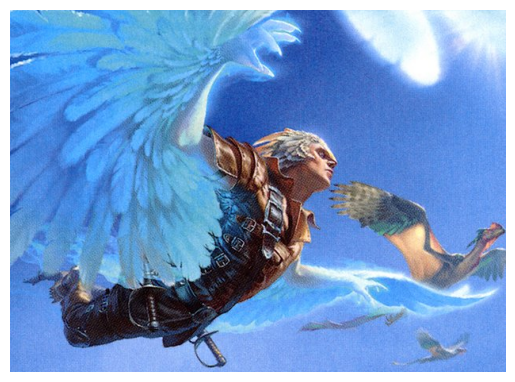

In [21]:
show_img_url(df['card_art_uri'][2])

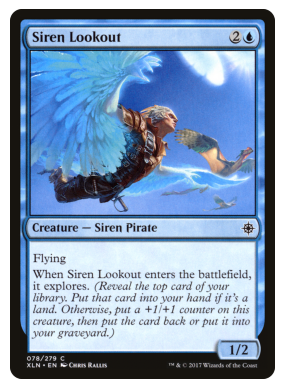

In [22]:
show_img_url(df['card_png_uri'][2])

In [23]:
df['scryfall_uri'][2]

'https://scryfall.com/card/xln/78/siren-lookout?utm_source=api'

In [24]:
def unique_values(col_name):
    col = np.vstack(df[col_name].values)
    unique_col, counts = np.unique(col.flatten(), return_counts=True)
    print(f"unique_{col_name}: len={len(unique_col)}\t\n values={unique_col}\t\n counts={counts}")
    print(50*"-")

unique_values("rarity")
unique_values("set_name")

unique_rarity: len=6	
 values=['bonus' 'common' 'mythic' 'rare' 'special' 'uncommon']	
 counts=[    9 14251  3011 12808   138 10057]
--------------------------------------------------
unique_set_name: len=710	
 values=['15th Anniversary Cards' '2016 Heroes of the Realm' '2017 Heroes of the Realm' ... 'Zendikar Rising Substitute Cards' 'Zendikar Rising Tokens' 'Zendikar Tokens']	
 counts=[ 1  3  3 ...  9 12 11]
--------------------------------------------------


In [25]:
vectors_base = np.vstack(df["open_clip_image_embeddings"].values)
rarity = np.vstack(df["rarity"].values)
set_name = np.vstack(df["set_name"].values)

In [26]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(rarity.shape)
print("First 5 rarity:")
print(rarity[:5])
print(50*'-')

print(set_name.shape)
print("First 5 set_name:")
print(set_name[:5])
print(50*'-')

(40274, 1152)
First 5 base vectors:
[[ 0.01548041 -0.00977236 -0.02203528 ... -0.00821519 -0.00849654 -0.01497478]
 [-0.00376118  0.01179656 -0.01300399 ...  0.02097553  0.00582058  0.00608341]
 [ 0.00346047 -0.00658036 -0.00275494 ...  0.01416791  0.00723666 -0.01654915]
 [-0.00093164 -0.01183124 -0.00819114 ...  0.00207677 -0.00973443 -0.01987386]
 [ 0.01229388  0.01600947 -0.01544499 ...  0.02004754 -0.01527324 -0.01044615]]
--------------------------------------------------
(40274, 1)
First 5 rarity:
[['uncommon']
 ['common']
 ['common']
 ['common']
 ['uncommon']]
--------------------------------------------------
(40274, 1)
First 5 set_name:
[['Time Spiral']
 ['Zendikar']
 ['Ixalan']
 ['Wilds of Eldraine']
 ['Throne of Eldraine']]
--------------------------------------------------


# glove-twitter-1m

In [27]:
read_rb(os.path.join(get_dataset_dir("glove-twitter-1m"), "glove.twitter.27B.100d.txt"), 38520, 38525)

Line 38520: b'\xe3\x83\x97\xe3\x83\xaa\xe3\x83\xb3\xe3\x82\xb9\xe3\x81\x95\xe3\x81\xbe\xe3\x81\xa3 0.49616 -0.047068 -1.5251 -1.6181 -0.74044 0.4508 -0.037198 0.52712 -0.60681 -1.6028 -1.9547 0.36121 -0.73566 0.84835 -0.82061 1.1719 -0.91779 0.83353 1.0021 -1.6792 -0.49819 0.59129 1.55 -1.4544 -0.67915 0.24279 0.64748 0.24315 -0.63128 0.77215 -0.14693 -0.61742 0.91588 0.56412 0.79568 0.97866 -0.04018 -0.83876 -0.39236 0.056948 0.42456 0.59819 -0.52171 0.26127 -2.0449 -0.20102 -0.7244 0.61089 0.43101 0.97293 0.24091 -0.16459 -0.68757 0.88532 1.431 -0.048325 -0.4141 -0.5862 0.33609 0.050795 -1.4044 -0.50616 -0.85319 0.93493 0.070508 -0.12786 0.42396 0.8102 -0.60614 -0.66896 -0.39232 -1.3509 0.34765 0.16754 1.1401 -0.56379 -0.75624 0.44027 -0.29765 -0.5916 1.2224 -0.42509 1.5938 0.07098 -0.76222 0.2076 -0.056926 -0.16724 0.60801 -0.34483 0.9929 0.32109 -0.74752 -0.31941 -0.80341 -0.57106 0.34389 -0.1741 0.319 -0.42714'
Line 38521: b'sujet 1.2106 -0.70863 -0.97707 0.33535 0.8257 0.36896 -0

In [28]:
vectors_base, words = read_glove(os.path.join(get_dataset_dir("glove-twitter-1m"), "glove.twitter.27B.100d.txt"), dim=100)

100%|██████████| 1193514/1193514 [00:20<00:00, 59279.40it/s]


In [29]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(words.shape)
print("First 5 words:")
print(words[:5])
print(50*'-')

(1193514, 100)
First 5 base vectors:
[[ 0.63006   0.65177   0.25545  ...  0.55096   0.64706  -0.6093  ]
 [ 0.18205  -0.048483  0.23966  ... -0.3358    0.18884  -0.40786 ]
 [ 1.0674    0.45716   0.51463  ...  0.13974   0.76487  -0.17314 ]
 [ 0.6047    0.89542   0.27923  ...  0.51566   0.84726   0.020946]
 [ 0.32299  -0.58293  -0.23327  ... -0.93883  -0.082771 -0.22574 ]]
--------------------------------------------------
(1193514, 1)
First 5 words:
[[b'<user>']
 [b'.']
 [b':']
 [b'rt']
 [b',']]
--------------------------------------------------


# glove-crawl-2m

In [30]:
read_rb(os.path.join(get_dataset_dir("glove-crawl-2m"), "glove.42B.300d.txt"), 38520, 38525)

Line 38520: b'officiants -0.27286 -0.26763 -0.19232 -0.47315 -0.17969 0.65251 0.29284 0.344 0.52798 0.73345 -0.14262 0.14965 -0.62599 0.95655 0.11174 0.3688 -0.17358 -0.4686 -0.25169 -0.24606 0.1069 0.46569 0.16384 0.567 -0.13116 -0.90364 -0.092945 0.25508 -0.42723 -0.35634 -0.33817 -0.54697 0.33896 0.80844 -0.074989 -0.295 -0.19337 0.10438 -0.64536 -0.0064417 0.5596 0.040017 -0.82994 0.068526 0.74293 0.038987 -0.087818 0.20967 -0.34419 0.33926 -0.08411 -0.35045 -0.36018 -0.063442 0.55642 0.20922 0.26115 0.13447 -1.1884 0.51219 -0.50801 0.29026 0.021666 -0.72874 -0.98283 -0.22902 -0.45908 0.40186 0.48242 0.096398 -0.81322 0.47401 0.066301 0.37852 0.61983 -0.026629 0.61008 1.1722 -0.63236 -1.0382 1.0478 -0.012739 0.14643 0.47032 0.53338 -0.81742 0.87329 -0.6313 1.2591 0.067921 -0.08494 -0.5833 -0.33783 0.34109 -0.61204 0.037358 -0.87564 0.13102 0.070601 0.65257 0.79364 -0.039221 0.55378 -0.46838 0.32975 1.0614 -0.74101 0.41003 -0.76908 0.17978 -0.79093 0.547 0.042016 0.14462 -0.3441 -0.

In [31]:
vectors_base, words = read_glove(os.path.join(get_dataset_dir("glove-crawl-2m"), "glove.42B.300d.txt"), dim=300)

100%|██████████| 1917494/1917494 [01:28<00:00, 21571.93it/s]


In [32]:
print(vectors_base.shape)
print("First 5 base vectors:")
print(vectors_base[:5])
print(50*'-')

print(words.shape)
print("First 5 words:")
print(words[:5])
print(50*'-')

(1917494, 300)
First 5 base vectors:
[[ 0.18378   -0.12123   -0.11987   ... -0.039038   0.18274    0.14654  ]
 [-0.20838   -0.14932   -0.017528  ... -0.54066    0.21199   -0.0094357]
 [ 0.10876    0.0022438  0.22213   ... -0.29696    0.15939   -0.14902  ]
 [-0.09611   -0.25788   -0.3586    ... -0.3703    -0.092774   0.39058  ]
 [-0.24837   -0.45461    0.039227  ...  0.053097   0.15458   -0.38053  ]]
--------------------------------------------------
(1917494, 1)
First 5 words:
[[b',']
 [b'the']
 [b'.']
 [b'and']
 [b'to']]
--------------------------------------------------


# laion-1m

In [37]:
df = read_parquet_files(get_dataset_dir("laion-1m"))

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


In [38]:
df

,image_path,caption,NSFW,similarity,LICENSE,url,key,shard_id,status,error_message,width,height,exif,original_width,original_height
0,000000033,2 bed Terraced p...,UNLIKELY,0.333244,?,http://media.rig...,33,19848,success,None,256,256,{},191,143
1,000000044,Teleflora's Simp...,UNLIKELY,0.301415,?,http://images.sh...,44,19848,success,None,256,256,{},274,300
2,000000052,Happy little gir...,UNLIKELY,0.332064,?,http://static9.d...,52,19848,success,None,256,256,{},110,110
3,000000015,Purple Forest...,UNLIKELY,0.370421,?,https://i.pinimg...,15,19848,success,None,256,256,{},236,351
4,000000043,Seamless metal b...,UNLIKELY,0.368341,?,https://cdn.vect...,43,19848,success,None,256,256,{},238,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000443,000007583,Number Names Wor...,UNLIKELY,0.362921,?,https://i.pinimg...,7583,19809,success,None,256,256,{},338,440
1000444,000006977,On CLOUDROCK WAT...,UNLIKELY,0.321525,?,https://media.gl...,6977,19809,success,None,256,256,None,170,170
1000445,000007556,Set of Pizza log...,UNLIKELY,0.356775,?,https://cdn.vect...,7556,19809,success,None,256,256,{},112,118
1000446,000007112,Choir Of Westmin...,UNLIKELY,0.346486,?,https://www.real...,7112,19809,success,None,256,256,{},300,300


In [39]:
vectors_image = np.load(os.path.join(get_dataset_dir("laion-1m"), "img_emb_0.npy"))
vectors_text = np.load(os.path.join(get_dataset_dir("laion-1m"), "text_emb_0.npy"))

In [40]:
print(vectors_image.shape)
print("First 5 image vectors:")
print(vectors_image[:5])
print(50*'-')

print(vectors_text.shape)
print("First 5 text vectors:")
print(vectors_text[:5])
print(50*'-')

(1000448, 512)
First 5 image vectors:
[[-0.01651   0.01602   0.03105  ... -0.01374  -0.02917  -0.0173  ]
 [-0.006847  0.03192   0.00832  ...  0.06335   0.003035  0.00457 ]
 [ 0.005665 -0.014786 -0.01548  ...  0.03485   0.04474   0.02869 ]
 [ 0.01802  -0.01203  -0.005833 ... -0.02147  -0.000746  0.0785  ]
 [-0.00944   0.03592   0.02454  ...  0.013824 -0.02945   0.0385  ]]
--------------------------------------------------
(1000448, 512)
First 5 text vectors:
[[ 6.672e-03  1.651e-02  6.110e-02 ...  5.902e-02 -9.918e-03 -2.342e-03]
 [ 3.464e-02 -4.826e-03  1.917e-02 ...  7.971e-02  1.410e-03 -8.057e-02]
 [-3.024e-02 -5.527e-02 -8.690e-03 ... -1.069e-02 -1.046e-03  9.823e-05]
 [ 2.786e-02 -1.715e-02  4.660e-02 ...  1.296e-02 -7.301e-03  1.305e-01]
 [-1.148e-02 -3.725e-03  9.865e-03 ...  2.428e-03  3.756e-03  3.610e-02]]
--------------------------------------------------


# youtube-8m

In [3]:
from tqdm import tqdm

dataset_dir = get_dataset_dir("youtube-6m")

# 获取所有以 train、valid、test 开头的 .tfrecord 文件
train_files = [f for f in os.listdir(dataset_dir) if f.startswith('train') and f.endswith('.tfrecord')]
valid_files = [f for f in os.listdir(dataset_dir) if f.startswith('valid') and f.endswith('.tfrecord')]
test_files = [f for f in os.listdir(dataset_dir) if f.startswith('test') and f.endswith('.tfrecord')]

# 输出各类文件数
print(f"Total number of train files: {len(train_files)}")
print(f"Total number of valid files: {len(valid_files)}")
print(f"Total number of test files: {len(test_files)}")
print(50*"-")

# 统计每个文件的记录数
def count_records(file_path):
    dataset = tf.data.TFRecordDataset(file_path)
    return sum(1 for _ in dataset)

# 统计并输出每个文件的记录数
def print_file_records(files):
    total_records = 0
    for file in tqdm(files):
        file_path = os.path.join(dataset_dir, file)
        record_count = count_records(file_path)
        total_records += record_count
    return total_records

# 输出各类文件数
train_total = print_file_records(train_files)
print(f"Total records of train files: {train_total}")
valid_total = print_file_records(valid_files)
print(f"Total records of valid files: {valid_total}")
test_total = print_file_records(test_files)
print(f"Total records of test files: {test_total}")
print(50*"-")

print(f"Total records: {train_total + valid_total + test_total}")
print(50*"-")

Total number of train files: 3844
Total number of valid files: 3844
Total number of test files: 3844
--------------------------------------------------


100%|██████████| 3844/3844 [06:00<00:00, 10.65it/s]


Total records of train files: 3888919


100%|██████████| 3844/3844 [03:23<00:00, 18.93it/s]


Total records of valid files: 1112356


100%|██████████| 3844/3844 [03:09<00:00, 20.25it/s]

Total records of test files: 1133323
--------------------------------------------------
Total records: 6134598
--------------------------------------------------


In [14]:
dataset_dir = get_dataset_dir("youtube-6m")
train_files = [f for f in os.listdir(dataset_dir) if f.startswith('train') and f.endswith('.tfrecord')]
train_files.sort()
df_list = []
# n = 0
for train_file in tqdm(train_files, total=len(train_files), dynamic_ncols=True):
    df_file = read_youtube6m(os.path.join(dataset_dir, train_file))
    df_list.append(df_file)
    # n += len(df_file)
    # if n > 100000:
    #     break
df = pd.concat(df_list, ignore_index=True)

  0%|          | 0/3844 [00:00<?, ?it/s]

100%|██████████| 3844/3844 [25:23<00:00,  2.52it/s]


In [15]:
df

,Sample ID,ID,Labels,Mean RGB,Mean Audio
0,1,[b'mpaa'],"[0, 1, 5, 69, 37...","[0.12678516, -0....","[0.2909387, 0.26..."
1,2,[b'inaa'],"[0, 215, 412]","[-0.9650502, 0.3...","[-1.2072463, -1...."
2,3,[b'VNaa'],[14],"[0.087556675, 0....","[1.1495781, 0.05..."
3,4,[b'qEaa'],"[31, 40, 57, 492]","[-1.2278999, 0.4...","[0.7615903, -1.0..."
4,5,[b'Q0aa'],"[31, 40, 47, 57]","[-1.0172945, 1.3...","[0.44814005, 0.6..."
...,...,...,...,...,...
3888914,1015,[b'IQ99'],"[6, 8, 812]","[1.2976588, 0.03...","[0.6068735, 0.91..."
3888915,1016,[b'Gc99'],"[3, 4, 6, 9, 10]","[-0.72672343, -0...","[0.7522831, -0.0..."
3888916,1017,[b'Zt99'],"[154, 263]","[-1.9414046, 1.5...","[0.50599277, 0.7..."
3888917,1018,[b'nG99'],[3182],"[1.2111516, 0.82...","[-0.84087706, -0..."


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888919 entries, 0 to 3888918
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Sample ID   int64 
 1   ID          object
 2   Labels      object
 3   Mean RGB    object
 4   Mean Audio  object
dtypes: int64(1), object(4)
memory usage: 148.4+ MB


In [17]:
meta_df = pd.read_csv(os.path.join(get_dataset_dir("youtube-6m"), "vocabulary.csv"))
meta_df.head(5)

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,0,788288,/m/03bt1gh,Game,https://en.wikip...,Games,NaN,NaN,A game is struct...
1,1,539945,/m/01mw1,Video game,https://en.wikip...,Games,NaN,NaN,A video game is ...
2,2,415890,/m/07yv9,Vehicle,https://en.wikip...,Autos & Vehicles,NaN,NaN,A vehicle is a m...
3,3,378135,/m/01jddz,Concert,https://en.wikip...,Arts & Entertain...,NaN,NaN,A concert is a l...
4,4,286532,/m/09jwl,Musician,https://en.wikip...,Arts & Entertain...,NaN,NaN,A musician is a ...


In [18]:
vectors_rgb = np.vstack(df["Mean RGB"].values)
vectors_audio = np.vstack(df["Mean Audio"].values)

In [19]:
print(vectors_rgb.shape)
print("First 5 rgb vectors:")
print(vectors_rgb[:5])
print(50*'-')

print(vectors_audio.shape)
print("First 5 audio vectors:")
print(vectors_audio[:5])
print(50*'-')

(3888919, 1024)
First 5 rgb vectors:
[[ 0.12678516 -0.55269563  0.20355953 ... -0.1983184   0.04360372 -0.37186164]
 [-0.9650502   0.35709354 -0.5095731  ...  1.9959432  -0.3480045   0.85110664]
 [ 0.08755668  0.25902852  0.09772246 ... -0.10922865 -0.03975125  0.0779968 ]
 [-1.2278999   0.4962308  -0.6061483  ... -0.22857966  0.8798648   0.29900205]
 [-1.0172945   1.3847488  -0.19163157 ... -1.2055298   0.15935634  0.24199475]]
--------------------------------------------------
(3888919, 128)
First 5 audio vectors:
[[ 0.2909387   0.2640953  -1.3249685  ...  0.5369481   0.08348221 -0.5262941 ]
 [-1.2072463  -1.1592987  -0.25085416 ... -1.0395601  -0.27422673  0.7502439 ]
 [ 1.1495781   0.05995421 -0.94450593 ... -0.09192662 -0.31557384 -0.04271346]
 [ 0.7615903  -1.038462   -0.57550776 ... -0.4595339   0.32885826  0.70668834]
 [ 0.44814005  0.60746694  0.9684916  ...  1.5027264  -0.91734713 -1.0996926 ]]
--------------------------------------------------
